import packages

In [ ]:
# Optional: detect Colab (not strictly needed for PyTorch)
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


Download data

In [ ]:

# Download data if not exists
if not os.path.exists('tiny_nerf_data.npz'):
    os.system('wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz')


device test

In [16]:
print(torch.backends.mps.is_available())

True


Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103


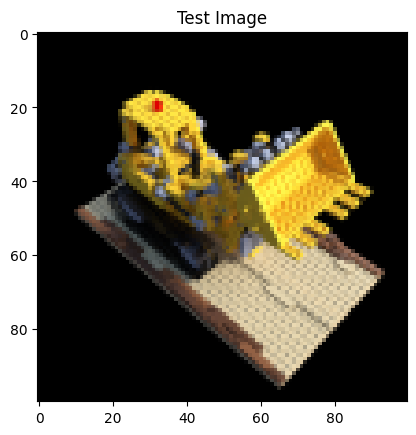

In [13]:

# Load data
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = float(data['focal'])  # Convert to Python float
H, W = images.shape[1:3]
print("Images shape:", images.shape)
print("Poses shape:", poses.shape)
print("Focal length:", focal)

# Holdout test image and pose
testimg, testpose = images[101], poses[101]
images = images[:100, ..., :3]  # Use first 100 for training
poses = poses[:100]

plt.imshow(testimg)
plt.title("Test Image")
plt.show()

In [14]:

# Positional encoding function
def posenc(x, L_embed=6):
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn((2.0 ** i) * x))
    return torch.cat(rets, dim=-1)

L_embed = 6
embed_fn = lambda x: posenc(x, L_embed=L_embed)

# NeRF MLP model
class NeRFModel(nn.Module):
    def __init__(self, D=8, W=256, input_ch=None, output_ch=4):
        super(NeRFModel, self).__init__()
        if input_ch is None:
            input_ch = 3 + 3 * 2 * L_embed
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.output_ch = output_ch

        layers = []
        layers.append(nn.Linear(input_ch, W))
        for i in range(D - 1):
            if i % 4 == 0 and i > 0:
                layers.append(nn.Linear(W + input_ch, W))
            else:
                layers.append(nn.Linear(W, W))
        self.layers = nn.ModuleList(layers)
        self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        inputs = x
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x))
            if i % 4 == 0 and i > 0:
                x = torch.cat([x, inputs], dim=-1)
        return self.output_linear(x)

# Ray generation
def get_rays(H, W, focal, c2w, device='cpu'):
    """
    focal: scalar tensor on the same device as c2w
    c2w: 4x4 camera-to-world matrix (tensor)
    """
    i, j = torch.meshgrid(
        torch.arange(W, dtype=torch.float32, device=device),
        torch.arange(H, dtype=torch.float32, device=device),
        indexing='xy'
    )
    dirs = torch.stack([
        (i - W * 0.5) / focal,
        -(j - H * 0.5) / focal,
        -torch.ones_like(i)
    ], dim=-1)  # [H, W, 3]

    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], dim=-1)  # [H, W, 3]
    rays_o = c2w[:3, -1].expand_as(rays_d)  # [H, W, 3]
    return rays_o, rays_d

# Render rays with volume rendering
def render_rays(model, rays_o, rays_d, near, far, N_samples, rand=False, device='cpu'):
    def batchify(fn, chunk=1024 * 32):
        def f(inputs):
            out = []
            for i in range(0, inputs.shape[0], chunk):
                out.append(fn(inputs[i:i+chunk]))
            return torch.cat(out, dim=0)
        return f

    # Sample depths
    t_vals = torch.linspace(near, far, N_samples, device=device)
    if rand:
        mids = 0.5 * (t_vals[..., 1:] + t_vals[..., :-1])
        upper = torch.cat([mids, t_vals[..., -1:]], dim=-1)
        lower = torch.cat([t_vals[..., :1], mids], dim=-1)
        t_rand = torch.rand(list(rays_o.shape[:-1]) + [N_samples], device=device)
        z_vals = lower + (upper - lower) * t_rand
    else:
        z_vals = t_vals.expand(list(rays_o.shape[:-1]) + [N_samples])

    # Compute 3D points along rays
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  # [H, W, N_samples, 3]

    # Run network
    pts_flat = pts.view(-1, 3)
    embedded = embed_fn(pts_flat)
    raw = batchify(model)(embedded)
    raw = raw.view(list(pts.shape[:-1]) + [4])

    # Volume rendering
    sigma = F.relu(raw[..., 3])  # [H, W, N_samples]
    rgb = torch.sigmoid(raw[..., :3])  # [H, W, N_samples, 3]

    dists = torch.cat([z_vals[..., 1:] - z_vals[..., :-1], torch.full_like(z_vals[..., :1], 1e10)], dim=-1)
    alpha = 1.0 - torch.exp(-sigma * dists)
    weights = alpha * torch.cumprod(
        torch.cat([torch.ones_like(alpha[..., :1]), 1.0 - alpha + 1e-10], dim=-1), dim=-1
    )[..., :-1]

    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [H, W, 3]
    depth_map = torch.sum(weights * z_vals, dim=-1)
    acc_map = torch.sum(weights, dim=-1)

    return rgb_map, depth_map, acc_map


Using device: mps
Iteration 0, 0.3553 secs per iter


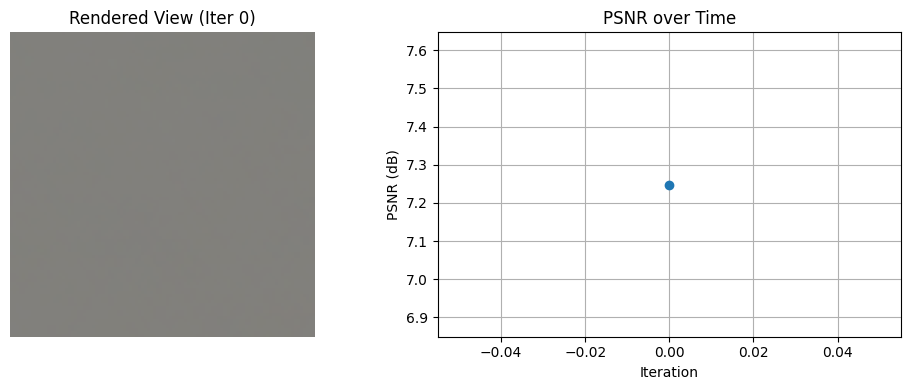

Iteration 25, 8.3888 secs per iter


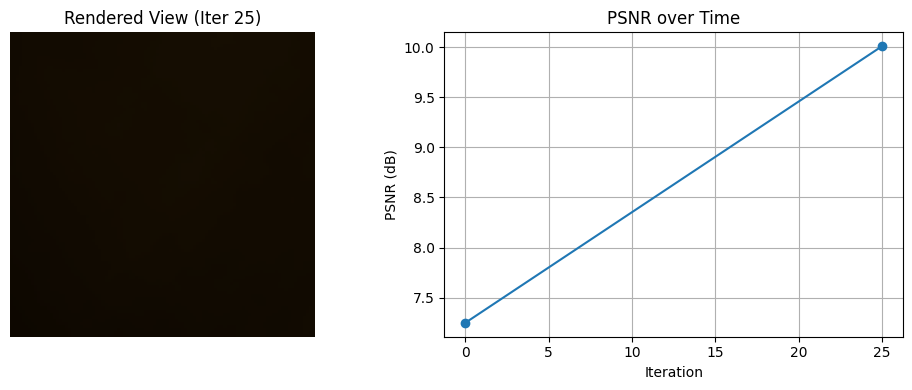

Iteration 50, 1.0632 secs per iter


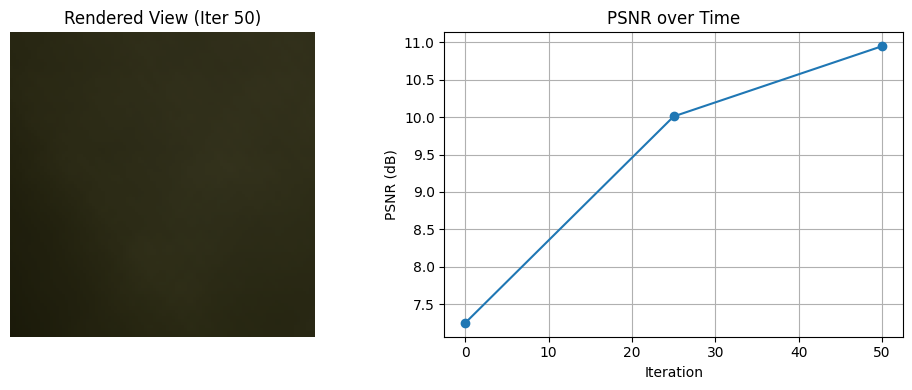

Iteration 75, 8.8276 secs per iter


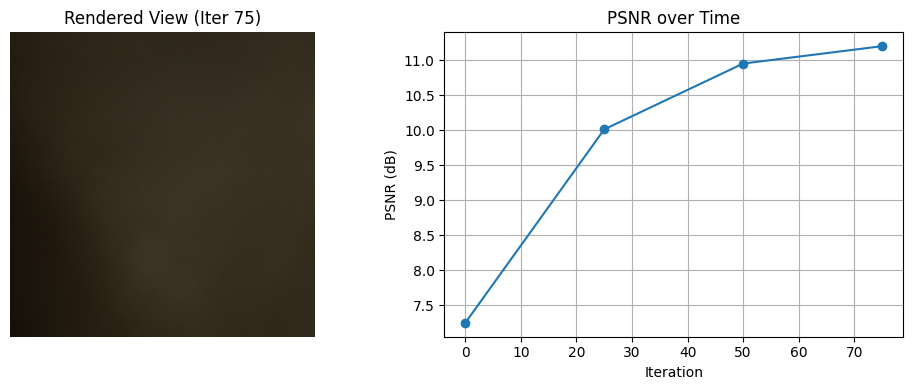

Iteration 100, 1.2478 secs per iter


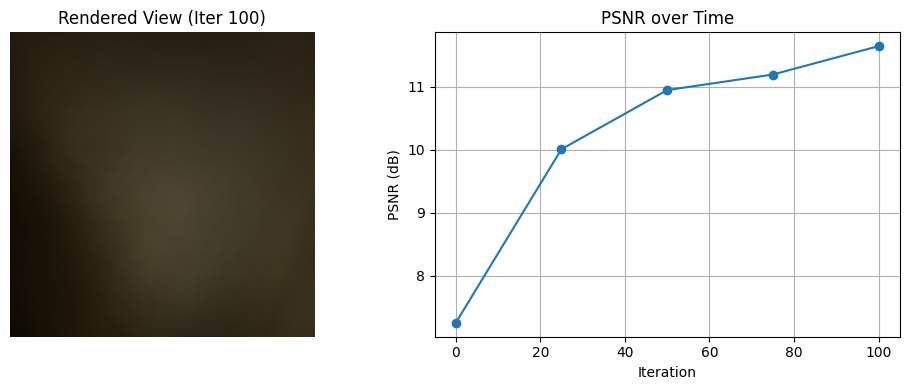

Iteration 125, 5.2128 secs per iter


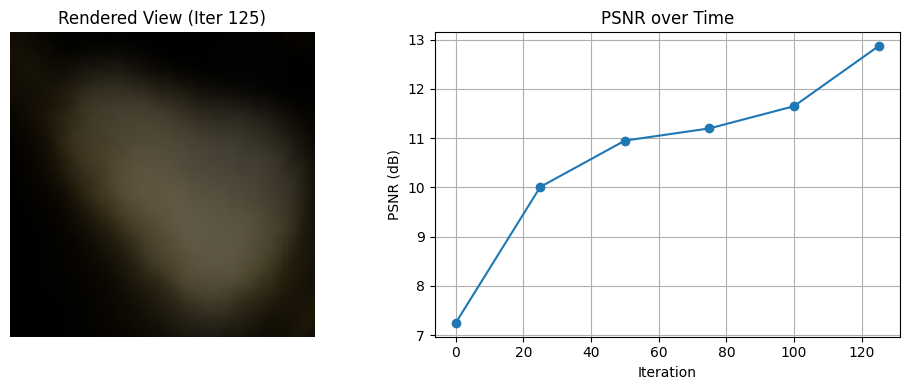

Iteration 150, 1.2491 secs per iter


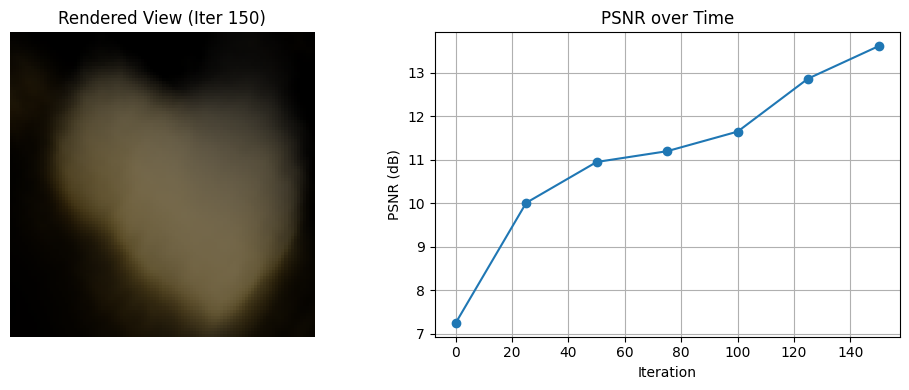

Iteration 175, 1.2608 secs per iter


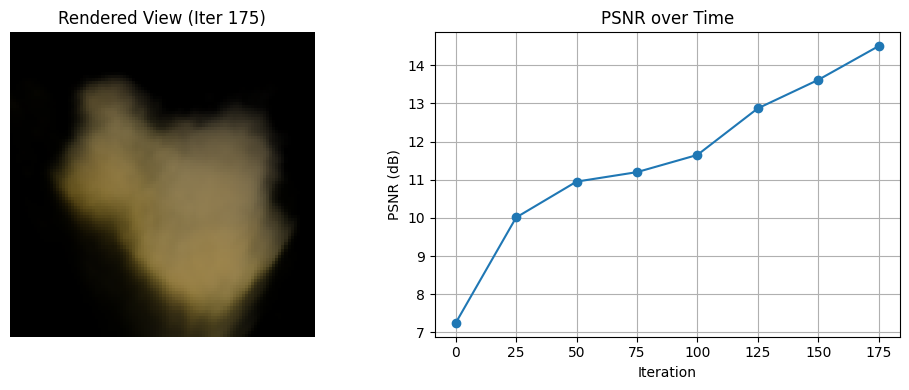

Iteration 200, 1.1662 secs per iter


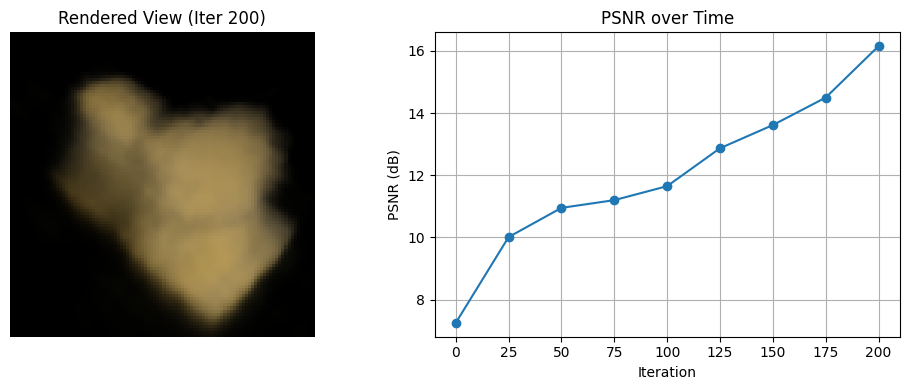

Iteration 225, 3.2067 secs per iter


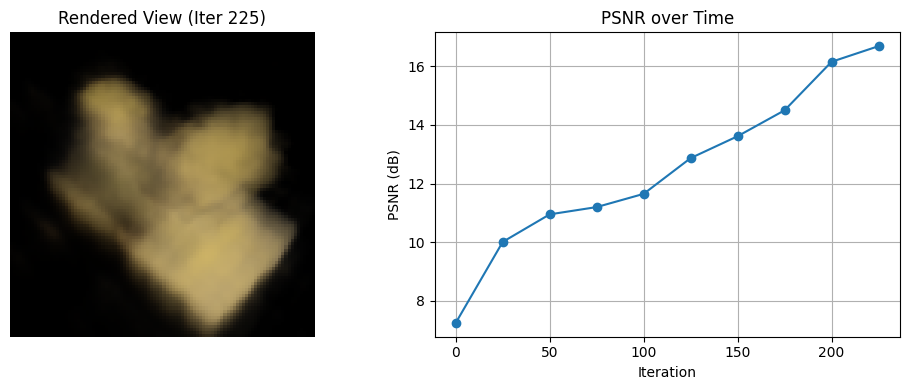

Iteration 250, 1.1025 secs per iter


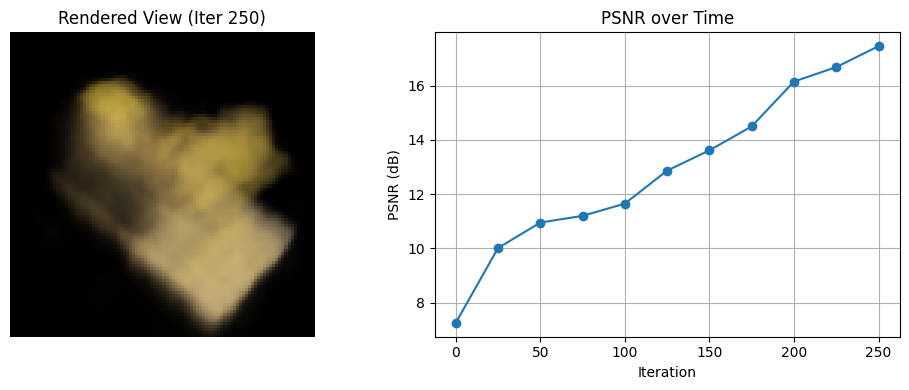

Iteration 275, 1.8424 secs per iter


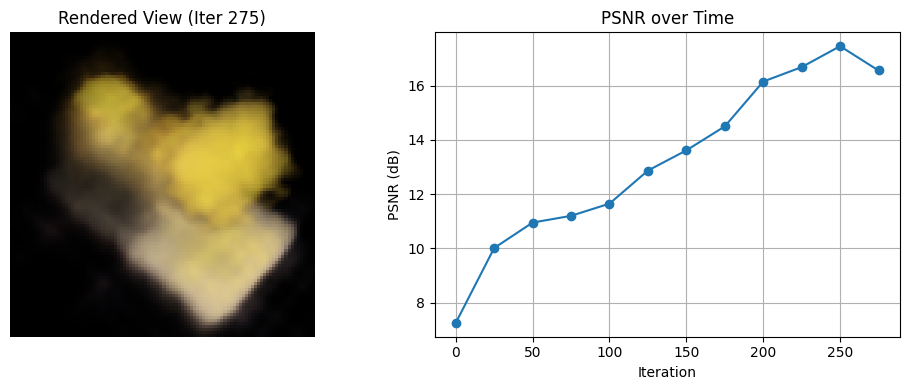

Iteration 300, 0.9992 secs per iter


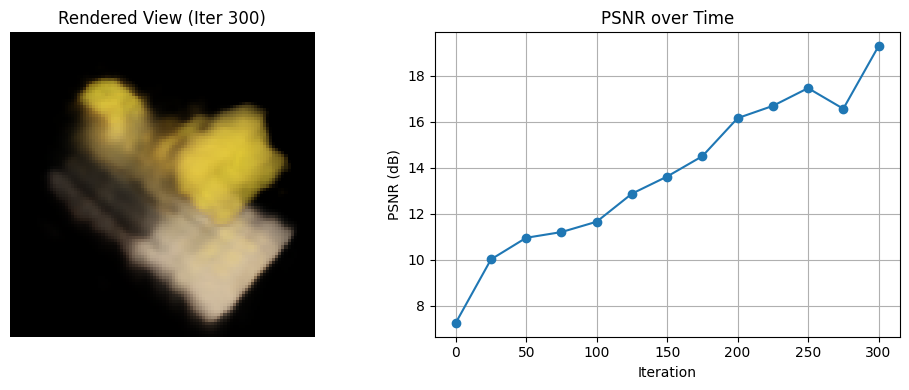

Iteration 325, 1.2084 secs per iter


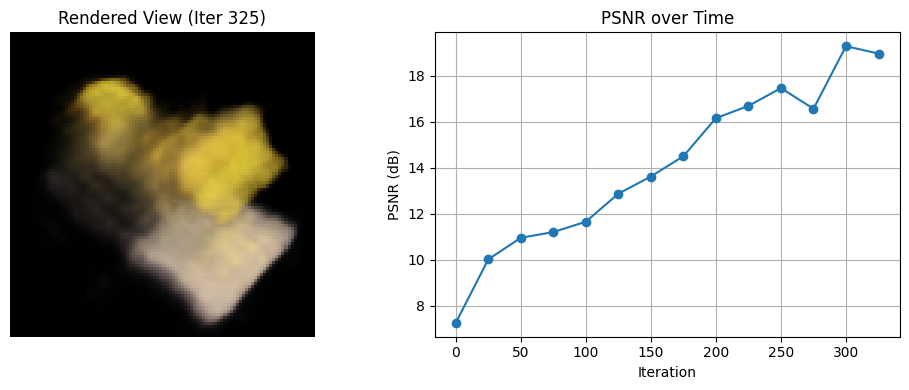

Iteration 350, 1.1452 secs per iter


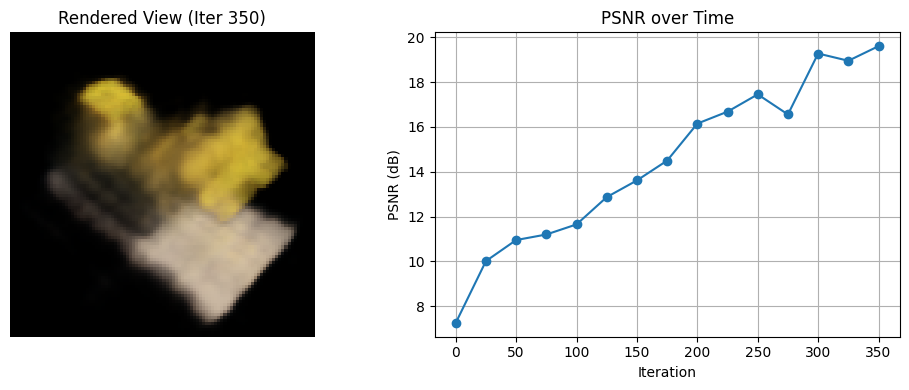

Iteration 375, 1.7907 secs per iter


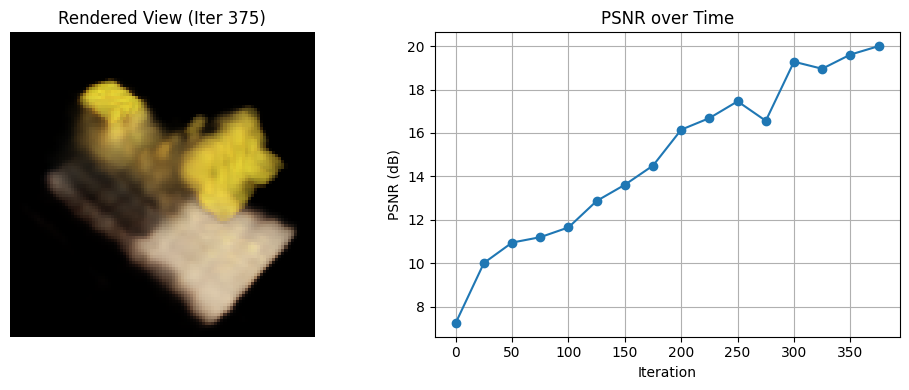

Iteration 400, 1.3746 secs per iter


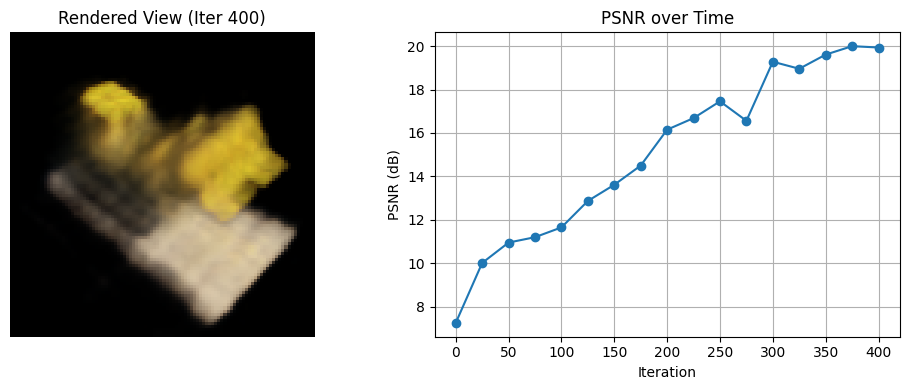

KeyboardInterrupt: 

In [17]:

# Device setup
if torch.cuda.is_available():
    device = torch.device('cuda')
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

# Convert data to tensors and move to device
images_torch = torch.from_numpy(images).float().to(device)
poses_torch = torch.from_numpy(poses).float().to(device)
testimg_torch = torch.from_numpy(testimg).float().to(device)
testpose_torch = torch.from_numpy(testpose).float().to(device)
focal_torch = torch.tensor(focal, dtype=torch.float32, device=device)

# Initialize model and optimizer
model = NeRFModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training config
N_samples = 64
N_iters = 1000
i_plot = 25
psnrs = []
iternums = []

import time
t = time.time()
for i in range(N_iters + 1):
    img_i = np.random.randint(images.shape[0])
    target = images_torch[img_i]
    pose = poses_torch[img_i]

    rays_o, rays_d = get_rays(H, W, focal_torch, pose, device=device)
    rgb, depth, acc = render_rays(
        model, rays_o, rays_d, near=2.0, far=6.0,
        N_samples=N_samples, rand=True, device=device
    )

    loss = F.mse_loss(rgb, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging and visualization
    if i % i_plot == 0:
        elapsed = time.time() - t
        print(f"Iteration {i}, {elapsed / i_plot:.4f} secs per iter")
        t = time.time()

        # Render test view
        rays_o_test, rays_d_test = get_rays(H, W, focal_torch, testpose_torch, device=device)
        rgb_test, _, _ = render_rays(
            model, rays_o_test, rays_d_test, near=2.0, far=6.0,
            N_samples=N_samples, rand=False, device=device
        )
        test_loss = F.mse_loss(rgb_test, testimg_torch)
        psnr = -10.0 * torch.log10(test_loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        # Plot results
        rgb_vis = rgb_test.detach().cpu().numpy()
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(np.clip(rgb_vis, 0.0, 1.0))
        plt.title(f'Rendered View (Iter {i})')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.plot(iternums, psnrs, '-o')
        plt.title('PSNR over Time')
        plt.xlabel('Iteration')
        plt.ylabel('PSNR (dB)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print("Training completed!")